In [1]:
#train.py
!pip install wandb
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import wandb
import matplotlib.pyplot as plt
import os

# Set up wandb
wandb.login(key="YOUR_WANDB_KEY")
wandb.init(project="ReversibleGAN", entity="YOUR_LOGIN")

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = F.normalize(torch.mv(torch.t(w.view(height,-1).data), u.data), dim=0, eps=1e-12)
            u.data = F.normalize(torch.mv(w.view(height,-1).data, v.data), dim=0, eps=1e-12)

        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _make_params(self):
        w = getattr(self.module, self.name)
        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = nn.Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = nn.Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = F.normalize(u.data, dim=0, eps=1e-12)
        v.data = F.normalize(v.data, dim=0, eps=1e-12)
        w_bar = nn.Parameter(w.data)

        del self.module._parameters[self.name]
        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)

    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

class ReversibleGAN(nn.Module):
    def __init__(self):
        super(ReversibleGAN, self).__init__()
        self.latent_dim = 64
        self.image_size = 28 * 28

        # Image to hidden layer
        self.image_to_hidden = SpectralNorm(nn.Linear(self.image_size, 512, bias=False))
        self.hidden_to_image = nn.Linear(512, self.image_size, bias=False)

        # Shared biases
        self.shared_biases = nn.ParameterList([
            nn.Parameter(torch.zeros(512)),
            nn.Parameter(torch.zeros(384)),
            nn.Parameter(torch.zeros(256)),
            nn.Parameter(torch.zeros(128)),
            nn.Parameter(torch.zeros(self.latent_dim)),
        ])

        # Encoder weights for discriminator
        self.encoder_weights = nn.ModuleList([
            SpectralNorm(nn.Linear(512, 384, bias=False)),
            SpectralNorm(nn.Linear(384, 256, bias=False)),
            SpectralNorm(nn.Linear(256, 128, bias=False)),
            SpectralNorm(nn.Linear(128, self.latent_dim, bias=False)),
        ])

        # Separate encoder weights
        self.separate_encoder_weights = nn.ModuleList([
            nn.Linear(self.image_size, 512, bias=False),
            nn.Linear(512, 384, bias=False),
            nn.Linear(384, 256, bias=False),
            nn.Linear(256, 128, bias=False),
            nn.Linear(128, self.latent_dim, bias=False),
        ])

        # Decoder weights for the generator
        self.decoder_weights = nn.ModuleList([
            nn.Linear(self.latent_dim, 128, bias=False),
            nn.Linear(128, 256, bias=False),
            nn.Linear(256, 384, bias=False),
            nn.Linear(384, 512, bias=False),
        ])

        # Digit probabilities layer for discriminator
        self.digit_probs = SpectralNorm(nn.Linear(self.latent_dim, 10))

        # Digit probs to latent layer
        self.digit_probs_to_latent = nn.Linear(10, self.latent_dim)

        # Digit probabilities layer for real images (used in encoder training)
        self.real_digit_probs = nn.Linear(self.latent_dim, 10)

    def encode(self, x):
        x = F.relu(self.image_to_hidden(x) + self.shared_biases[0])
        for i, (layer, bias) in enumerate(zip(self.encoder_weights, self.shared_biases[1:])):
            x = F.relu(layer(x) + bias)
        return x

    def separate_encode(self, x):
        x = x.view(x.size(0), -1)
        for i, (layer, bias) in enumerate(zip(self.separate_encoder_weights, self.shared_biases)):
            x = F.relu(layer(x) + bias)
        x = self.real_digit_probs(x)  # Final layer to get class probabilities
        return x

    def decode(self, x):
        for i, (layer, bias) in enumerate(zip(self.decoder_weights, self.shared_biases[-2::-1])):
            x = F.relu(layer(x) + bias)
        x = F.relu(self.hidden_to_image(x))
        return x

    def generate(self, digit_probs, noise):
        latent = self.digit_probs_to_latent(digit_probs) + noise
        return self.decode(latent)

    def discriminate(self, pixels):
        latent = self.encode(pixels)
        return self.digit_probs(latent)

# Initialize the model
model = ReversibleGAN().to(device)

# Optimizer for the encoder (updates both shared biases and separate encoder weights)
optimizer_E = optim.Adam(model.parameters(), lr=0.0001, betas=(0.5, 0.999))

# Optimizer for the generator (only updates decoder weights)
optimizer_G = optim.Adam(model.parameters(), lr=0.0001, betas=(0.5, 0.999))

# Optimizer for the discriminator (only updates encoder weights)
optimizer_D = optim.Adam(model.parameters(), lr=0.00038, betas=(0.5, 0.999))


# Define loss function
criterion = nn.CrossEntropyLoss(reduction='none')

def gradient_penalty(discriminator, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1, device=device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = discriminator(interpolates)
    fake = torch.ones(real_samples.size(0), 10, device=device, requires_grad=False)  # Changed to 10
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

def adversarial_loss(real_output, real_labels, fake_output, fake_labels):
    batch_size = real_output.size(0)

    # Label smoothing
    real_labels_smooth = torch.full((batch_size,), 0.9, device=device)

    # Wasserstein-like loss
    d_loss_real = -torch.mean(real_output.gather(1, real_labels.unsqueeze(1)))
    d_loss_fake = torch.mean(fake_output.gather(1, fake_labels.unsqueeze(1)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = -torch.mean(fake_output.gather(1, fake_labels.unsqueeze(1)))

    # Compute accuracies
    real_accuracy = torch.mean((real_output.argmax(1) == real_labels).float())
    fake_accuracy = torch.mean((fake_output.argmax(1) == fake_labels).float())

    return d_loss, g_loss, real_accuracy.item(), fake_accuracy.item()

def evaluate_model(model, device, num_samples=1000):
    model.eval()
    total_accuracy = 0
    with torch.no_grad():
        for _ in range(num_samples):
            fake_labels = torch.randint(0, 10, (1,)).to(device)
            fake_probs = F.one_hot(fake_labels, num_classes=10).float()
            noise = torch.randn(1, model.latent_dim).to(device)
            fake_images = model.generate(fake_probs, noise)
            fake_output_E = model.separate_encode(fake_images)
            predicted_label = fake_output_E.argmax(1)
            total_accuracy += (predicted_label == fake_labels).float().item()

    avg_accuracy = total_accuracy / num_samples
    model.train()
    return avg_accuracy

def save_model(model, filename):
    if not os.path.exists('models'):
        os.makedirs('models')
    torch.save(model.state_dict(), f'models/{filename}')
    print(f"Model saved as {filename}")

def train(model, train_loader, optimizer_E, optimizer_G, optimizer_D, criterion, device):
    model.train()
    total_e_loss = 0
    total_d_loss = 0
    total_g_loss = 0

    for batch_idx, (real_images, real_labels) in enumerate(train_loader):
        real_images, real_labels = real_images.to(device), real_labels.to(device)
        batch_size = real_images.size(0)

        # Train Encoder
        optimizer_E.zero_grad()
        real_output_E = model.separate_encode(real_images)
        e_loss_real = criterion(real_output_E, real_labels)
        e_loss = e_loss_real.mean()
        e_loss.backward()
        optimizer_E.step()

        # Calculate Encoder accuracies
        e_real_accuracy = torch.mean((real_output_E.argmax(1) == real_labels).float())

        # Train Discriminator
        optimizer_D.zero_grad()
        real_output_D = model.discriminate(real_images.view(batch_size, -1))

        # Generate fake images
        fake_labels = torch.randint(0, 10, (batch_size,)).to(device)
        fake_probs = F.one_hot(fake_labels, num_classes=10).float()
        noise = torch.randn(batch_size, model.latent_dim).to(device)
        fake_images = model.generate(fake_probs, noise)
        fake_output_D = model.discriminate(fake_images.detach())

        # Calculate adversarial loss
        d_loss, _, d_real_accuracy, d_fake_accuracy = adversarial_loss(real_output_D, real_labels, fake_output_D, fake_labels)

        # Gradient penalty
        gp = gradient_penalty(model.discriminate, real_images.view(batch_size, -1), fake_images.detach())
        d_loss += 10 * gp

        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        fake_output_D = model.discriminate(fake_images)
        _, g_loss, _, _ = adversarial_loss(real_output_D, real_labels, fake_output_D, fake_labels)

        g_loss.backward()
        optimizer_G.step()

        # Calculate Encoder accuracy on fake images
        fake_output_E = model.separate_encode(fake_images.detach())
        e_fake_accuracy = torch.mean((fake_output_E.argmax(1) == fake_labels).float())

        # Accumulate losses
        total_e_loss += e_loss.item()
        total_d_loss += d_loss.item()
        total_g_loss += g_loss.item()

        # Log to wandb
        wandb.log({
            "D_loss": d_loss.item(),
            "G_loss": g_loss.item(),
            "E_loss": e_loss.item(),
            "E_real_accuracy": e_real_accuracy.item(),
            "E_fake_accuracy": e_fake_accuracy.item(),
            "D_real_accuracy": d_real_accuracy,
            "D_fake_accuracy": d_fake_accuracy,
        })

        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx}/{len(train_loader)}, Encoder Loss: {e_loss.item():.4f}, D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")
            print(f"E_real_acc: {e_real_accuracy.item():.4f}, E_fake_acc: {e_fake_accuracy.item():.4f}, D_real_acc: {d_real_accuracy:.4f}, D_fake_acc: {d_fake_accuracy:.4f}")

    return total_e_loss / len(train_loader), total_d_loss / len(train_loader), total_g_loss / len(train_loader)

def generate_and_display_samples(model, epoch, device):
    model.eval()
    with torch.no_grad():
        num_samples = 10  # One for each digit from 0 to 9

        # Generate digit probabilities for 0 to 9
        fake_labels = torch.arange(10).to(device)
        fake_probs = F.one_hot(fake_labels, num_classes=10).float()

        # Generate noise
        noise = torch.randn(num_samples, model.latent_dim).to(device)

        # Generate fake images
        fake_images = model.generate(fake_probs, noise)

        # Reshape and scale images
        fake_images = fake_images.view(num_samples, 1, 28, 28)
        fake_images = fake_images * 0.3081 + 0.1307  # Denormalize

        # Create a figure with subplots
        fig, axes = plt.subplots(2, 5, figsize=(15, 6))
        fig.suptitle(f'Generated Samples (0-9) - Epoch {epoch}')

        # Plot each image
        for i in range(num_samples):
            row = i // 5
            col = i % 5
            ax = axes[row, col]
            ax.imshow(fake_images[i].squeeze().cpu().numpy(), cmap='gray')
            ax.axis('off')
            ax.set_title(f'Label: {i}')

        # Adjust layout and display the plot
        plt.tight_layout()
        plt.show()

        # Log to wandb
        wandb.log({"generated_samples": wandb.Image(fig, caption=f"Epoch {epoch}")})

    model.train()  # Set the model back to training mode

# Training loop
num_epochs = 20
best_e_fake_accuracy = 0

# Train Encoder, Discriminator, and Generator together
for epoch in range(num_epochs):
    print(f"Starting epoch {epoch+1}/{num_epochs}")
    e_loss, d_loss, g_loss = train(model, train_loader, optimizer_E, optimizer_G, optimizer_D, criterion, device)

    # Evaluate the model
    current_e_fake_accuracy = evaluate_model(model, device)

    print(f'Epoch {epoch+1}/{num_epochs}, Encoder Loss: {e_loss:.4f}, D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}, E Fake Accuracy: {current_e_fake_accuracy:.4f}')

    # Check if this is the best e_fake_accuracy so far
    if current_e_fake_accuracy > best_e_fake_accuracy:
        best_e_fake_accuracy = current_e_fake_accuracy
        save_model(model, f'best_model_e_fake_acc_{best_e_fake_accuracy:.4f}.pth')
        print(f"New best e_fake_accuracy: {best_e_fake_accuracy:.4f}")

    # Log to wandb
    wandb.log({
        "epoch": epoch + 1,
        "E_loss": e_loss,
        "D_loss": d_loss,
        "G_loss": g_loss,
        "E_fake_accuracy": current_e_fake_accuracy,
        "Best_E_fake_accuracy": best_e_fake_accuracy
    })

    # Generate and display samples
    generate_and_display_samples(model, epoch + 1, device)

print("Training completed!")
wandb.finish()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.0 MB/s eta 0:00:00
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 455, in run
    installed = install_given_reqs(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/req/__init__.py", line 70, in install_given_reqs
    requirement.install(
  File "/usr/local/lib/python3.10/dist-packages/pip/_in

KeyboardInterrupt: 

In [9]:
# Save the model
torch.save(model.state_dict(), 'ReversibleGAN.pth')

Accuracy of Discriminator (image to label): 11.36%
Accuracy of Encoder (image to label): 97.91%


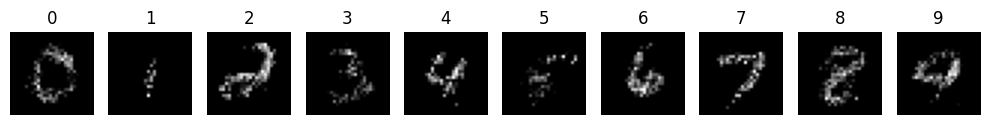

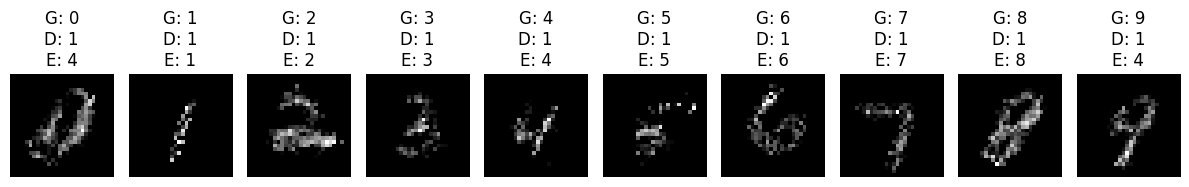

Accuracy of Discriminator on generated images: 10.00%
Accuracy of Encoder on generated images: 80.00%


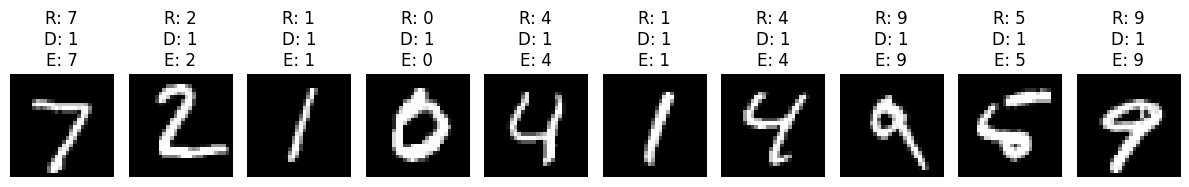

Accuracy of Discriminator on real images: 20.00%
Accuracy of Encoder on real images: 100.00%


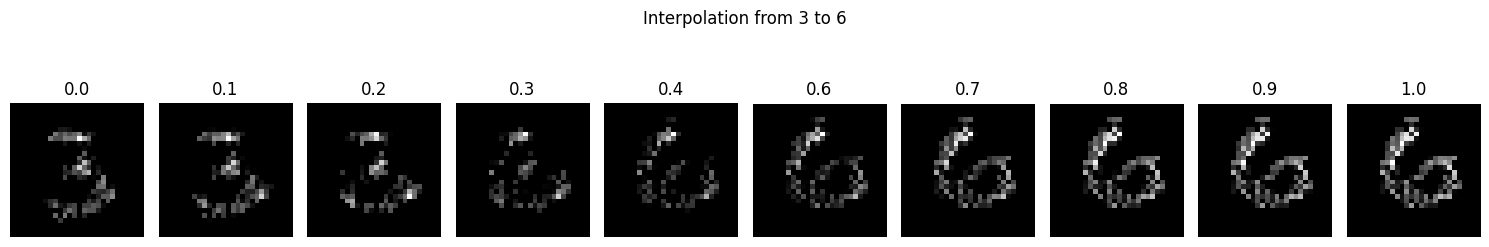

In [14]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

# Define transforms (same as in the main code)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load test dataset
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def test_image_to_label(model, test_loader, device):
    model.eval()
    correct_d = 0
    correct_e = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data_flattened = data.view(data.size(0), -1)

            # Discriminator prediction
            output_d = model.discriminate(data_flattened)
            predicted_label_d = output_d.argmax(dim=1)

            # Encoder prediction
            output_e = model.separate_encode(data)  # Use separate_encode for encoder
            predicted_label_e = output_e.argmax(dim=1)

            total += target.size(0)
            correct_d += (predicted_label_d == target).sum().item()
            correct_e += (predicted_label_e == target).sum().item()

    accuracy_d = 100 * correct_d / total
    accuracy_e = 100 * correct_e / total
    print(f'Accuracy of Discriminator (image to label): {accuracy_d:.2f}%')
    print(f'Accuracy of Encoder (image to label): {accuracy_e:.2f}%')

def test_label_to_image(model, device):
    model.eval()
    plt.figure(figsize=(10, 2))
    with torch.no_grad():
        for digit in range(10):
            input_label = F.one_hot(torch.tensor([digit]), num_classes=10).float().to(device)
            noise = torch.randn(1, model.latent_dim).to(device)
            output = model.generate(input_label, noise)

            plt.subplot(1, 10, digit + 1)
            plt.imshow(output[0].view(28, 28).cpu().numpy(), cmap='gray')
            plt.title(f"{digit}")
            plt.axis('off')
    plt.tight_layout()
    plt.show()

def test_generated_image_classification(model, device):
    model.eval()
    plt.figure(figsize=(12, 3))  # Adjusted figure size
    correct_d = 0
    correct_e = 0
    total = 10

    with torch.no_grad():
        for digit in range(10):
            input_label = F.one_hot(torch.tensor([digit]), num_classes=10).float().to(device)
            noise = torch.randn(1, model.latent_dim).to(device)
            generated_image = model.generate(input_label, noise)

            # Discriminator prediction
            classification_output_d = model.discriminate(generated_image)
            predicted_label_d = classification_output_d.argmax(dim=1).item()

            # Encoder prediction
            classification_output_e = model.separate_encode(generated_image)
            predicted_label_e = classification_output_e.argmax(dim=1).item()

            plt.subplot(1, 10, digit + 1)  # Only one row now
            plt.imshow(generated_image[0].view(28, 28).cpu().numpy(), cmap='gray')
            plt.title(f"G: {digit}\nD: {predicted_label_d}\nE: {predicted_label_e}")  # Combined title
            plt.axis('off')

            if predicted_label_d == digit:
                correct_d += 1
            if predicted_label_e == digit:
                correct_e += 1

    plt.tight_layout()
    plt.show()

    accuracy_d = 100 * correct_d / total
    accuracy_e = 100 * correct_e / total
    print(f'Accuracy of Discriminator on generated images: {accuracy_d:.2f}%')
    print(f'Accuracy of Encoder on generated images: {accuracy_e:.2f}%')

def test_real_image_classification(model, test_loader, device):
    model.eval()
    plt.figure(figsize=(12, 3)) # Adjusted figure size
    correct_d = 0
    correct_e = 0
    total = 0

    with torch.no_grad():
        data, target = next(iter(test_loader))
        data, target = data[:10].to(device), target[:10].to(device)
        data_flattened = data.view(data.size(0), -1)

        # Discriminator prediction
        output_d = model.discriminate(data_flattened)
        predicted_label_d = output_d.argmax(dim=1)

        # Encoder prediction
        output_e = model.separate_encode(data)
        predicted_label_e = output_e.argmax(dim=1)

        for i in range(10):
            plt.subplot(1, 10, i + 1)  # Only one row now
            plt.imshow(data[i].squeeze().cpu().numpy(), cmap='gray')
            plt.title(f"R: {target[i].item()}\nD: {predicted_label_d[i].item()}\nE: {predicted_label_e[i].item()}")
            plt.axis('off')

            if predicted_label_d[i] == target[i]:
                correct_d += 1
            if predicted_label_e[i] == target[i]:
                correct_e += 1
            total += 1

    plt.tight_layout()
    plt.show()

    accuracy_d = 100 * correct_d / total
    accuracy_e = 100 * correct_e / total
    print(f'Accuracy of Discriminator on real images: {accuracy_d:.2f}%')
    print(f'Accuracy of Encoder on real images: {accuracy_e:.2f}%')

def test_latent_space_interpolation(model, device):
    model.eval()
    plt.figure(figsize=(15, 3))

    with torch.no_grad():
        # Choose two random digits
        start_digit = np.random.randint(0, 10)
        end_digit = np.random.randint(0, 10)

        start_label = F.one_hot(torch.tensor([start_digit]), num_classes=10).float().to(device)
        end_label = F.one_hot(torch.tensor([end_digit]), num_classes=10).float().to(device)

        start_noise = torch.randn(1, model.latent_dim).to(device)
        end_noise = torch.randn(1, model.latent_dim).to(device)

        for i in range(10):
            alpha = i / 9
            interpolated_label = start_label * (1 - alpha) + end_label * alpha
            interpolated_noise = start_noise * (1 - alpha) + end_noise * alpha

            generated_image = model.generate(interpolated_label, interpolated_noise)

            plt.subplot(1, 10, i + 1)
            plt.imshow(generated_image[0].view(28, 28).cpu().numpy(), cmap='gray')
            plt.title(f"{alpha:.1f}")
            plt.axis('off')

    plt.suptitle(f"Interpolation from {start_digit} to {end_digit}")
    plt.tight_layout()
    plt.show()

# Assuming you have already trained the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ReversibleGAN().to(device)
model.load_state_dict(torch.load('/content/best_model_e_fake_acc_0.7330.pth', map_location=device))

# Run the tests
test_image_to_label(model, test_loader, device)
test_label_to_image(model, device)
test_generated_image_classification(model, device)
test_real_image_classification(model, test_loader, device)
test_latent_space_interpolation(model, device)

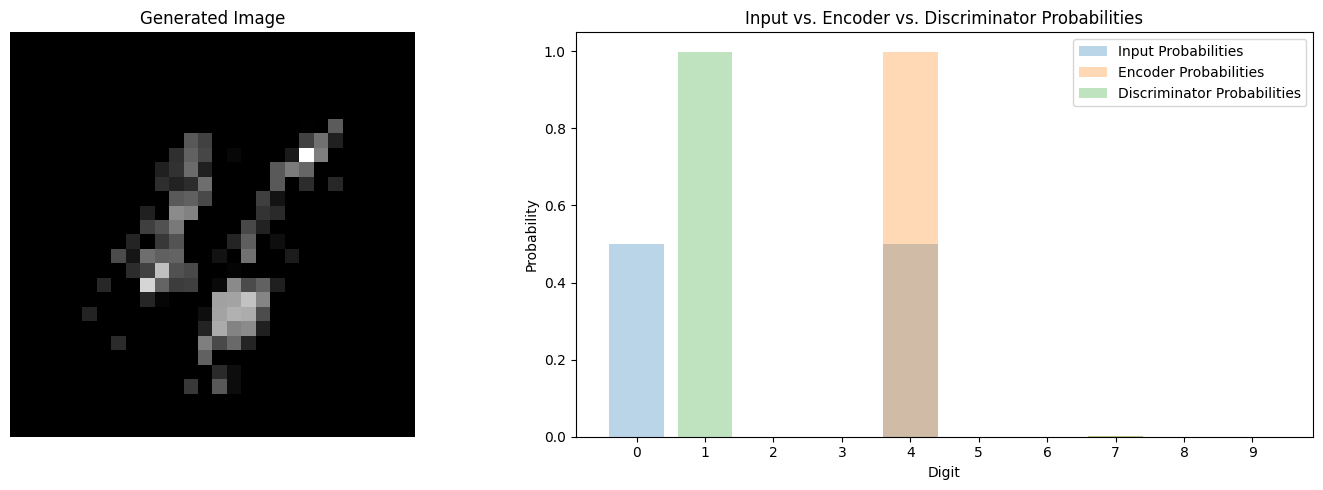

Input probabilities: [0.5 0.  0.  0.  0.5 0.  0.  0.  0.  0. ]
Encoder probabilities: [1.2512182e-10 3.9156119e-04 1.3738078e-08 1.4927567e-12 9.9854159e-01
 2.9804003e-06 7.9839668e-07 1.0630402e-03 3.1749483e-09 1.8289839e-09]
Discriminator probabilities: [9.0066930e-16 9.9927264e-01 2.0180504e-12 7.0965028e-10 6.7380183e-14
 6.6959814e-26 1.7099748e-12 7.2735758e-04 2.8006051e-08 5.7346128e-11]


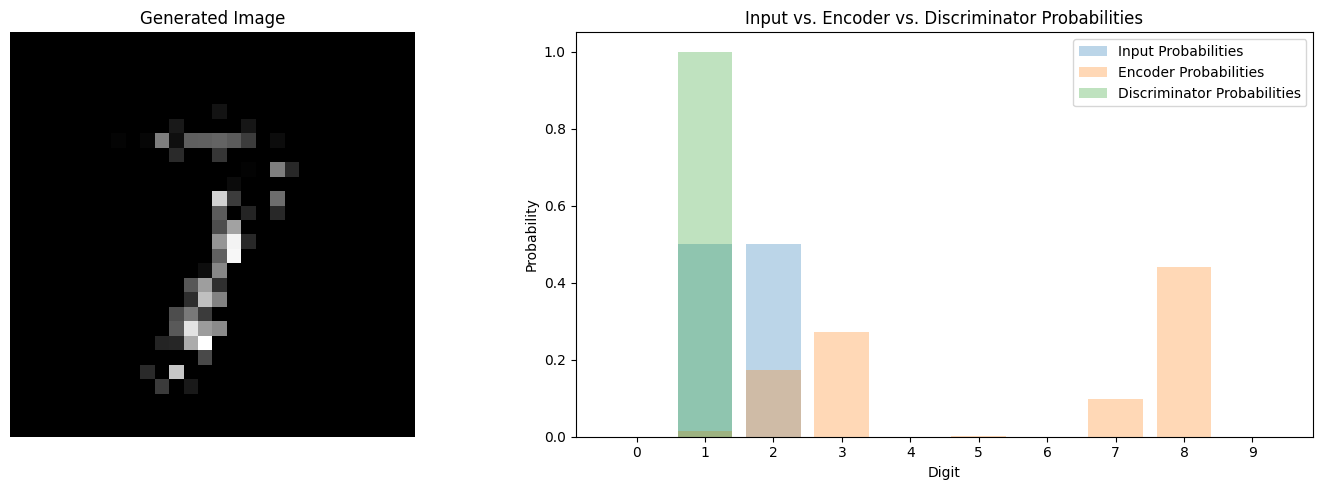

Input probabilities: [0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
Encoder probabilities: [8.1888301e-09 1.4650761e-02 1.7288151e-01 2.7071911e-01 1.1560599e-06
 2.9846414e-03 3.7703589e-06 9.7169138e-02 4.4158503e-01 4.8559782e-06]
Discriminator probabilities: [3.4781687e-17 9.9994016e-01 2.8182925e-13 3.5634200e-11 2.5681006e-14
 2.2854528e-26 1.0093541e-12 5.9875081e-05 3.9838182e-09 2.5745095e-11]


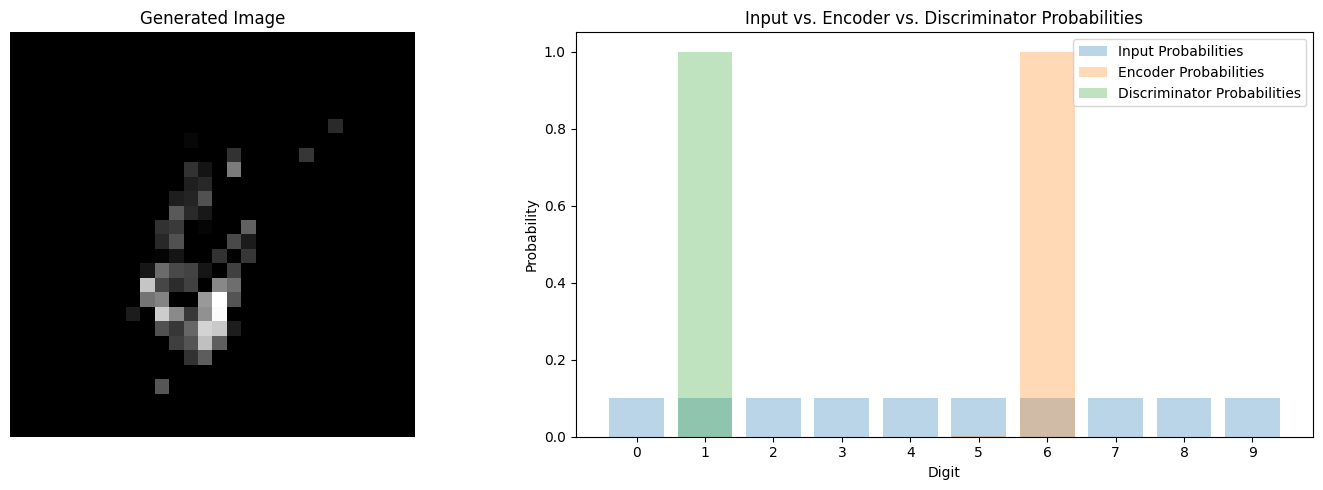

Input probabilities: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Encoder probabilities: [4.3545376e-10 1.7986450e-08 4.5605193e-06 3.2903049e-08 2.1792799e-09
 8.3951693e-04 9.9912459e-01 1.6129194e-08 3.1377142e-05 3.7901000e-13]
Discriminator probabilities: [2.05698815e-16 9.99948978e-01 3.27441037e-13 1.02450465e-10
 5.85528398e-14 1.08005116e-25 2.70436061e-12 5.10407408e-05
 1.05768434e-08 4.07317756e-11]


In [20]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def test_custom_digit_probabilities(model, device, custom_probs):
    model.eval()

    # Ensure custom_probs is a valid probability distribution
    custom_probs = torch.tensor(custom_probs).float()
    if custom_probs.sum() != 1.0:
        custom_probs = F.softmax(custom_probs, dim=0)

    custom_probs = custom_probs.unsqueeze(0).to(device)  # Add batch dimension

    plt.figure(figsize=(15, 5))

    with torch.no_grad():
        # Generate image from custom probabilities
        noise = torch.randn(1, model.latent_dim).to(device)
        generated_image = model.generate(custom_probs, noise)

        # Use the Encoder to get digit probabilities
        encoded_output = model.separate_encode(generated_image)
        predicted_probs_encoder = F.softmax(encoded_output, dim=1)

        # Use the Discriminator to get digit probabilities
        discriminator_output = model.discriminate(generated_image.view(1, -1))
        predicted_probs_discriminator = F.softmax(discriminator_output, dim=1)

        # Plot the generated image
        plt.subplot(1, 2, 1)
        plt.imshow(generated_image[0].view(28, 28).cpu().numpy(), cmap='gray')
        plt.title("Generated Image")
        plt.axis('off')

        # Plot the input, encoder, and discriminator probabilities
        plt.subplot(1, 2, 2)
        x = range(10)
        plt.bar(x, custom_probs[0].cpu().numpy(), alpha=0.3, label='Input Probabilities')
        plt.bar(x, predicted_probs_encoder[0].cpu().numpy(), alpha=0.3, label='Encoder Prediction')
        plt.bar(x, predicted_probs_discriminator[0].cpu().numpy(), alpha=0.3, label='Discriminator Prediction')
        plt.xlabel('Digit')
        plt.ylabel('Probability')
        plt.title('Input vs. Encoder vs. Discriminator Probabilities')
        plt.legend()
        plt.xticks(x)

    plt.tight_layout()
    plt.show()

    print("Input probabilities:", custom_probs[0].cpu().numpy())
    print("Encoder probabilities:", predicted_probs_encoder[0].cpu().numpy())
    print("Discriminator probabilities:", predicted_probs_discriminator[0].cpu().numpy())

# Example usage remains the same:
custom_probs = [0.5, 0, 0., 0.0, 0.5, 0.0, 0.0, 0, 0, 0]  # Example probabilities
test_custom_digit_probabilities(model, device, custom_probs)

mix_probs = [0, 0.5, 0.5, 0, 0, 0, 0., 0, 0., 0]  # 50% 1 and 50% 2
test_custom_digit_probabilities(model, device, mix_probs)

uniform_probs = [0.1] * 10
test_custom_digit_probabilities(model, device, uniform_probs)

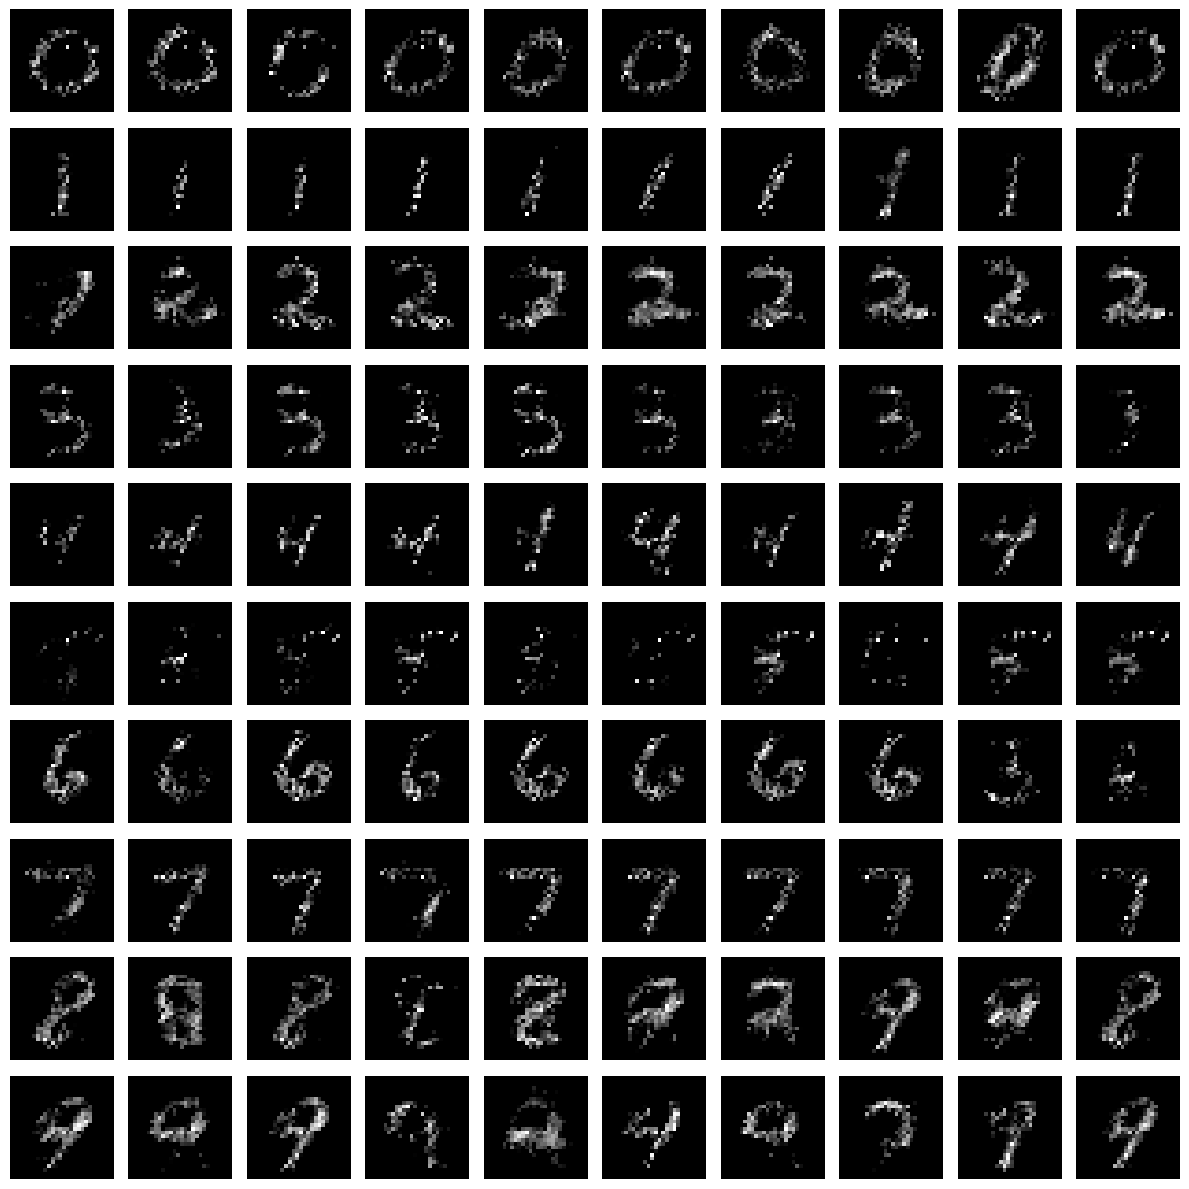

In [14]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

def create_digit_collage(model, device):
    model.eval()
    plt.figure(figsize=(12, 12))

    with torch.no_grad():
        for row in range(10):
            for col in range(10):
                digit = row
                input_label = F.one_hot(torch.tensor([digit]), num_classes=10).float().to(device)
                noise = torch.randn(1, model.latent_dim).to(device)
                generated_image = model.generate(input_label, noise)

                plt.subplot(10, 10, row * 10 + col + 1)
                plt.imshow(generated_image[0].view(28, 28).cpu().numpy(), cmap='gray')
                plt.axis('off')

    plt.tight_layout()
    plt.show()

# Assuming you have already loaded the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ReversibleGAN().to(device)
model.load_state_dict(torch.load('/content/best_model_e_fake_acc_0.7330.pth', map_location=device))

# Create the collage
create_digit_collage(model, device)

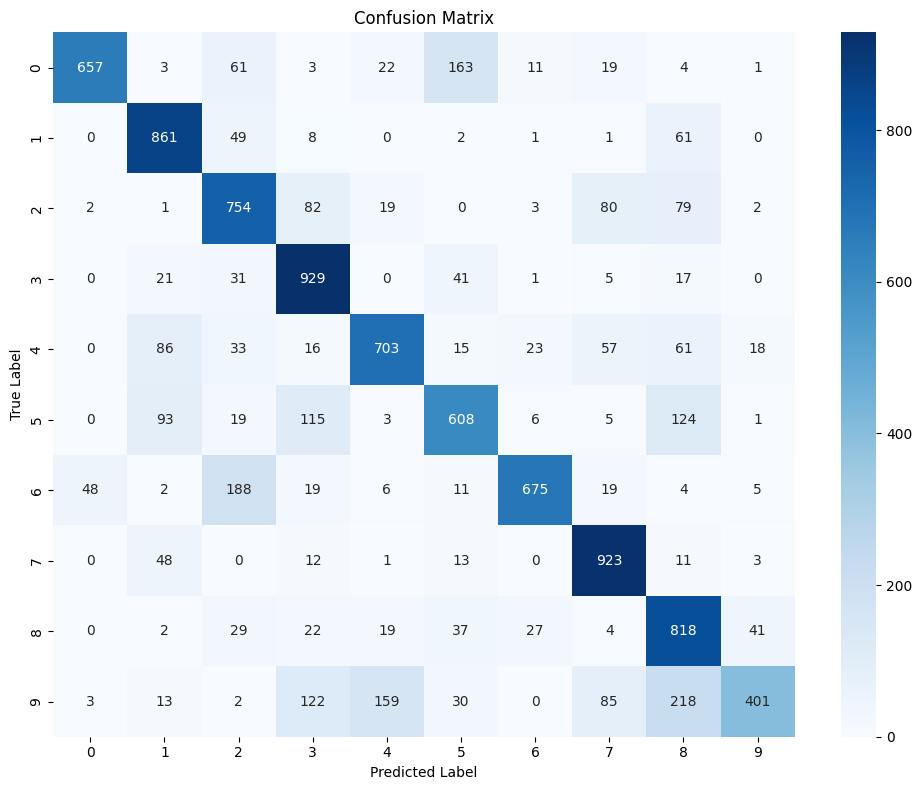

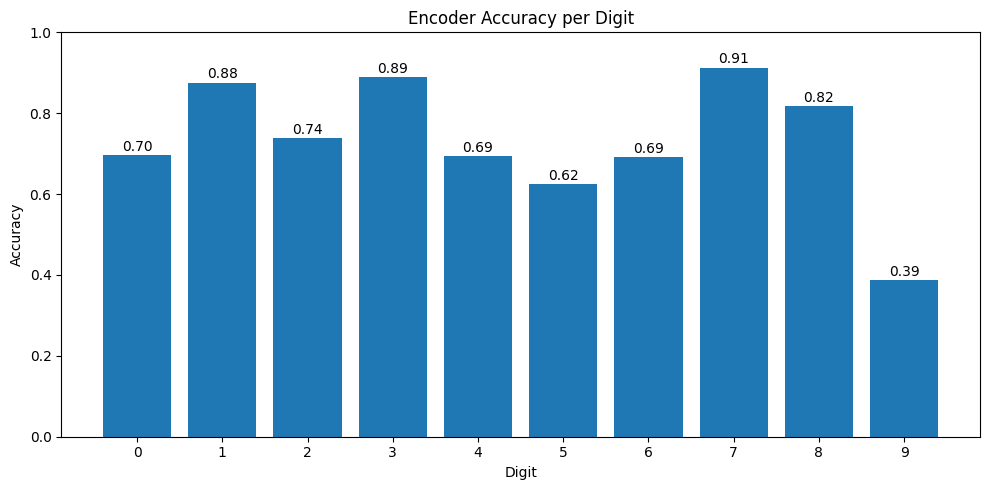

Overall Accuracy: 0.7329
Digit 0 Accuracy: 0.6960
Digit 1 Accuracy: 0.8759
Digit 2 Accuracy: 0.7378
Digit 3 Accuracy: 0.8890
Digit 4 Accuracy: 0.6947
Digit 5 Accuracy: 0.6242
Digit 6 Accuracy: 0.6909
Digit 7 Accuracy: 0.9130
Digit 8 Accuracy: 0.8188
Digit 9 Accuracy: 0.3882

Confusion Matrix:
[[657   3  61   3  22 163  11  19   4   1]
 [  0 861  49   8   0   2   1   1  61   0]
 [  2   1 754  82  19   0   3  80  79   2]
 [  0  21  31 929   0  41   1   5  17   0]
 [  0  86  33  16 703  15  23  57  61  18]
 [  0  93  19 115   3 608   6   5 124   1]
 [ 48   2 188  19   6  11 675  19   4   5]
 [  0  48   0  12   1  13   0 923  11   3]
 [  0   2  29  22  19  37  27   4 818  41]
 [  3  13   2 122 159  30   0  85 218 401]]


In [27]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

def evaluate_random_digits(model, device, num_samples=10000):
    model.eval()
    correct = 0
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for _ in range(num_samples):
            # Generate a random digit (0-9)
            true_digit = np.random.randint(0, 10)
            input_label = F.one_hot(torch.tensor([true_digit]), num_classes=10).float().to(device)

            # Generate image
            noise = torch.randn(1, model.latent_dim).to(device)
            generated_image = model.generate(input_label, noise)

            # Encode the generated image
            encoded_output = model.separate_encode(generated_image)
            predicted_digit = encoded_output.argmax(dim=1).item()

            # Update counters and lists
            if predicted_digit == true_digit:
                correct += 1
            true_labels.append(true_digit)
            predicted_labels.append(predicted_digit)

    # Calculate overall accuracy
    overall_accuracy = correct / num_samples

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    # Calculate accuracies per digit
    digit_accuracies = cm.diagonal() / cm.sum(axis=1)

    # Plot accuracies per digit
    plt.figure(figsize=(10, 5))
    digits = list(range(10))
    plt.bar(digits, digit_accuracies)
    plt.xlabel('Digit')
    plt.ylabel('Accuracy')
    plt.title('Encoder Accuracy per Digit')
    plt.xticks(digits)
    plt.ylim(0, 1)
    for i, v in enumerate(digit_accuracies):
        plt.text(i, v + 0.01, f'{v:.2f}', ha='center')
    plt.tight_layout()
    plt.show()

    # Print overall accuracy
    print(f"Overall Accuracy: {overall_accuracy:.4f}")

    return overall_accuracy, digit_accuracies, cm

# Assuming you have your model and device set up
# model = YourModel().to(device)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Run the evaluation
overall_accuracy, digit_accuracies, confusion_mat = evaluate_random_digits(model, device)

# If you want to print individual digit accuracies
for digit, accuracy in enumerate(digit_accuracies):
    print(f"Digit {digit} Accuracy: {accuracy:.4f}")

# If you want to access the confusion matrix
print("\nConfusion Matrix:")
print(confusion_mat)

In [41]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from matplotlib.animation import FFMpegWriter

def digit_interpolation_animation(model, device, num_frames=60, fps=30):
    model.eval()

    # Choose two random digits
    start_digit = np.random.randint(0, 10)
    end_digit = np.random.randint(0, 10)
    while end_digit == start_digit:
        end_digit = np.random.randint(0, 10)

    start_label = F.one_hot(torch.tensor([start_digit]), num_classes=10).float().to(device)
    end_label = F.one_hot(torch.tensor([end_digit]), num_classes=10).float().to(device)

    # Generate fixed noise
    noise = torch.randn(1, model.latent_dim).to(device)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    plt.close()  # Prevent displaying the empty figure

    img_plot = ax1.imshow(torch.zeros(28, 28), cmap='gray', vmin=0, vmax=1)
    ax1.axis('off')
    ax1.set_title("Generated Image")

    x = range(10)
    bar_plots = [ax2.bar(x, torch.zeros(10), alpha=0.3) for _ in range(3)]
    ax2.set_ylim(0, 1)
    ax2.set_title('Input vs. Encoder vs. Discriminator Probabilities')
    ax2.set_xlabel("Digit")
    ax2.set_ylabel("Probability")
    ax2.set_xticks(x)
    ax2.set_xticklabels(x)  # Ensure all labels are shown

    # Move legend outside the plot
    ax2.legend(['Input Probabilities', 'Encoder Prediction', 'Discriminator Prediction'],
               loc='upper right', bbox_to_anchor=(1, 1))

    fig.suptitle(f"Interpolation from {start_digit} to {end_digit}", fontsize=16)

    # Adjust layout to make room for the legend
    plt.tight_layout()
    plt.subplots_adjust(right=0.85)

    def animate(frame):
        alpha = frame / (num_frames - 1)
        interpolated_label = start_label * (1 - alpha) + end_label * alpha

        with torch.no_grad():
            generated_image = model.generate(interpolated_label, noise)

            # Get encoder and discriminator predictions
            encoded_output = model.separate_encode(generated_image)
            predicted_probs_encoder = F.softmax(encoded_output, dim=1)

            discriminator_output = model.discriminate(generated_image.view(1, -1))
            predicted_probs_discriminator = F.softmax(discriminator_output, dim=1)

            # Update image plot
            img_plot.set_array(generated_image[0].view(28, 28).cpu().numpy())

            # Update bar plots
            probabilities = [
                interpolated_label[0].cpu().numpy(),
                predicted_probs_encoder[0].cpu().numpy(),
                predicted_probs_discriminator[0].cpu().numpy()
            ]

            for bars, heights in zip(bar_plots, probabilities):
                for bar, height in zip(bars, heights):
                    bar.set_height(height)

        return [img_plot] + [bar for bars in bar_plots for bar in bars]

    anim = FuncAnimation(fig, animate, frames=num_frames, interval=1000/fps, blit=True)
    plt.close(anim._fig)
    return anim, start_digit, end_digit

# Usage:
# Assuming you have your model and device set up
# model = YourModel().to(device)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Generate the animation
animation, start_digit, end_digit = digit_interpolation_animation(model, device)

# Save the animation as an MP4 video
writer = FFMpegWriter(fps=30, metadata=dict(artist='Me'), bitrate=1800)
animation.save(f'digit_interpolation_{start_digit}_to_{end_digit}.mp4', writer=writer)

print(f"Animation saved as 'digit_interpolation_{start_digit}_to_{end_digit}.mp4'")

# If you want to display the animation in a Jupyter notebook, you can still use:
# from IPython.display import HTML
# HTML(animation.to_jshtml())

Animation saved as 'digit_interpolation_3_to_4.mp4'


<Figure size 640x480 with 0 Axes>